In [1]:
import os
import numpy as np
import scipy.io as sci_io
import matplotlib.pyplot as plt
import nitime.algorithms as tsa
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import warnings
import math
from math import e
import neo as ne
import scipy as sc
import scipy.signal as signal
from pathlib import Path
warnings.filterwarnings('ignore')
import quantities as pq
from scipy.signal import hilbert, chirp
from scipy.signal import butter, sosfilt, sosfreqz, resample

In [2]:
DataDir = 'E:/Documents/ALESSANDRA/PROPAGATION/DC/BMI_Almu/181009/Rec06_3BMI04_DC5'
# DataDir = './frontalD300'

File1 = DataDir + '/Sig.mat'
mat_contents = sci_io.loadmat(File1)
Signal=mat_contents['S']
fs=9.9206e+03
rs=np.array(Signal)

File2 = DataDir + '/Mua.mat'
mat_contents2 = sci_io.loadmat(File2)
Mua=mat_contents2['Mua']

fsMua=198.4127

MUA=np.zeros((16,np.shape(rs)[1]))
for i in range(16):
    MUA[i,:]=resample(Mua[i],np.shape(rs)[1])

In [3]:
analytic_signal=[]
amplitude_envelope=[]
instantaneous_phase=np.zeros((16,np.shape(rs)[1]))
iph=np.zeros((16,np.shape(rs)[1]))
instantaneous_frequency=np.zeros((16,np.shape(rs)[1]))

for ch in range(len(rs)):
    an_sig=hilbert(rs[ch])
#     analytic_signal=(an_sig)
#     amplitude_envelope=(np.abs(an_sig))
    instantaneous_phase[ch,:]=((np.angle(an_sig)))
    iph[ch,:]=np.unwrap(np.angle(an_sig))
#     instantaneous_frequency[ch,:] = (np.diff(iph) /(2.0*np.pi) * fs)

In [4]:
B=np.arange(-math.pi,math.pi+0.15707963267948966,0.15707963267948966)
ph=np.empty((16))
H=np.zeros((np.shape(B)[0]-1,np.shape(rs)[1]))

for t in range(len(instantaneous_phase[0])):
    for ch in range(len(instantaneous_phase)):
#         print(ch,t)
        ph[ch]=instantaneous_phase[ch][t]
    hist, b = np.histogram(ph,bins=B)
    H[:,t]=hist
    ph=np.empty((16))

In [5]:
Dph=np.empty((120))
dH=np.zeros((np.shape(B)[0]-1,np.shape(rs)[1]))

n=0

for t in range(np.shape(instantaneous_phase)[1]):
    for i in range(0,16):
        for j in range(i+1,16):
            Dph[n]=(instantaneous_phase[i][t]-instantaneous_phase[j][t])
            n=n+1

    
    hist, b = np.histogram(Dph,bins=B)
    dH[:,t]=hist
    Dph=np.empty((120))
    n=0       

In [6]:
synch=np.empty(len(instantaneous_phase[0]))
s=0
for t in range(len(instantaneous_phase[0])):
    for ch in range(16):
        s = s + e ** complex(0,instantaneous_phase[ch][t])
    synch[t]=(1/16)*abs(s)
    s=0

In [7]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
# fs = 30.0       # sample rate, Hz
cutoff = 10  # desired cutoff frequency of the filter, Hz
# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
data = synch
# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)

Mean_synch=np.mean(synch)
print(Mean_synch)

0.2774411290515398


(0, 1686509)

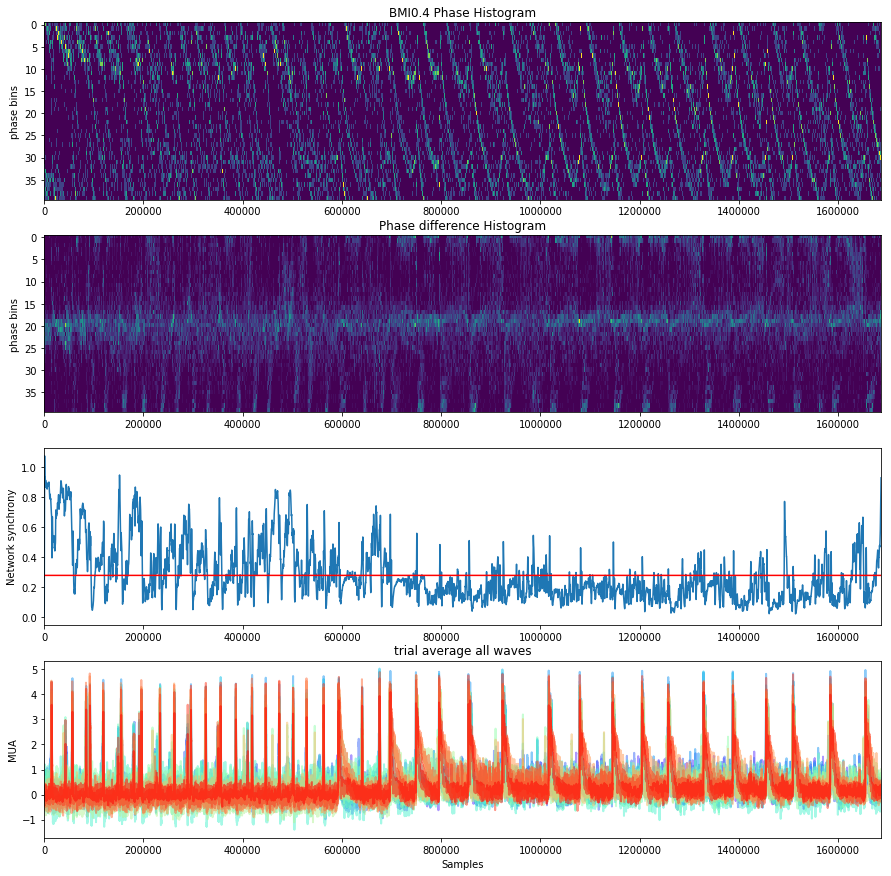

In [8]:
plt.figure(figsize=(15, 15))
ax=plt.subplot(411)
aa=plt.imshow(H, aspect='auto')
aa.set_clim(0,5)
# plt.colorbar(aa)
plt.title('BMI0.4 Phase Histogram')
plt.ylabel('phase bins')
ax1=plt.subplot(412,sharex=ax)
ax1=plt.imshow(dH, aspect='auto')
ax1.set_clim(0,30)
# plt.colorbar(ax1)
plt.title('Phase difference Histogram')
plt.ylabel('phase bins')
ax2=plt.subplot(413,sharex=ax)
plt.plot(y)
plt.plot(np.ones(len(y))*Mean_synch,'r')
# plt.plot(sH,'g')
plt.ylabel('Network synchrony')
ax3=plt.subplot(414,sharex=ax)

from matplotlib.pyplot import cm
color=cm.rainbow(np.linspace(0,1,16))
    
for sig, c in zip(MUA, color):
    plt.plot(sig, c=c, alpha=0.5, linewidth=2)  # dibujo
    plt.title('trial average all waves')   

# plt.plot(MUA[0])
# plt.plot(MUA[31])
plt.ylabel('MUA')
plt.xlabel('Samples')
plt.xlim(0,len(MUA[0]))